In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense,LSTM,MultiHeadAttention,LayerNormalization,GlobalAveragePooling1D
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import MeanAbsoluteError
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from time import perf_counter
import os,logging
import warnings

2025-04-24 15:09:29.300475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 15:09:29.300518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 15:09:29.302519: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 15:09:29.513862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### you could delete/surpase this line here (os one)
- i needed it cause im using wsl for tensorflow, but in normal windows, its possible to remove it or just dont run it.

In [4]:
os.chdir('/tf-acno-projects/Project-Data-Mining')

In [5]:
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True, precision=3) ## for disabling numpy scientific representation
## tensorflow warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [6]:
TIME_STEP = 12 ## steps we take as input (1 == 1 month ) (12 = 12 months)
INPUT_SHAPE = (TIME_STEP,3) # (time_step, features)
LR = 0.0001
EPOCHS = 80
N_SPLITS = 5 # cross val splits
D_MODEL = 512 # units (neurons)
CALLBACK = [
    # useful to reduce the lr automatically when the loss doesnt shrinks after each 20 epochs
    ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=10, min_delta=0.0001, min_lr=1e-7,),
    ]


SEQ_LEN = TIME_STEP
NUM_HEADS = 16
KEY_DIM = D_MODEL//NUM_HEADS

In [7]:
def X_y_forecasting_splits(Datafile,time_steps):
    """
    Splits dataset into X,y seperate datasets with respect of the split window (time_steps)
    """
    X,y = list(),list()
    for start in range(len(Datafile)):
        end = start+time_steps 
        if end>len(Datafile)-1:
            break
        X.append(Datafile.iloc[start:end].values)
        y.append(Datafile.iloc[end]["CO2 Emission"])
    return np.array(X),np.array(y)

In [8]:
def months_converter(DataFile):
    """
    Convert months string values into numerical values
    """
    unique_months = DataFile['Month'].unique()
    months_dict = {
        month:idx+1 for idx,month in enumerate(unique_months)
    }
    DataFile['Month'] = DataFile['Month'].map(months_dict)

In [9]:
def lstm_architecture(input_shape,lr,d_model):
    """
    LSTM ARCHITECTURE 
    """
    input_layer = Input(shape=input_shape)
    hidden_layer = LSTM(d_model, return_sequences=True)(input_layer)
    hidden_layer = LSTM(d_model//2, return_sequences=True)(hidden_layer)
    hidden_layer = LSTM(d_model//2, return_sequences=True)(hidden_layer)
    hidden_layer = LSTM(d_model//4)(hidden_layer)
    hidden_layer = Dense(d_model//8,activation='relu')(hidden_layer)
    output_layer = Dense(1,activation='linear')(hidden_layer)

    lstm_model = Model(input_layer,output_layer)
    lstm_model.compile(optimizer=Adam(learning_rate=lr),loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])
    return lstm_model

In [10]:
def positional_encoding(sequence_length,d_model,n=10000):
    """
    Positional Encoding Function to add a proper ordering for our dataset
    - d_model: the dimension of our input ( output of the embedding space )
    - sequence_length: the length of our sequence for example we have 3 features then its 3
    """
    PosEnc = np.zeros((sequence_length,d_model))
    indices = np.arange(int(d_model/2))
    positions = np.arange((sequence_length))
    
    for position in positions:
        for index in indices:
            denomenator = np.power(n,2*index/d_model)
            PosEnc[position,2*index] = np.sin(position/denomenator)
            PosEnc[position,2*index+1] = np.cos(position/denomenator)

    pos_enc_tensor = tf.constant(PosEnc, dtype=tf.float32)
    pos_enc_tensor = tf.reshape(pos_enc_tensor, (1, sequence_length, d_model))
    return pos_enc_tensor

In [11]:
def transformer_embedding_positioning(sequence_length,d_model,input_layer):
    """
    Tranforming the dataset input into an embedding vector that contains the data ordered and ready for the transformer use
    - We use **the embedding** which is a way to convert raw input into a high-dimensional vector (d_model in this case).
        so our embedding vector shape is **(batch_size,time,features_embedding)**
    - **Positional encoding** is added to this embedding vector so the model knows about the position of each token or feature.
    """
    x_embedded = Dense(d_model)(input_layer)
    pos_enc = positional_encoding(sequence_length,d_model)
    return x_embedded + pos_enc

In [12]:
def transformer_encoder(x,d_model,num_heads,key_dim):
    """
    The Encoder part of the transformer architecture
    """
    attention_layer = MultiHeadAttention(num_heads=num_heads,key_dim=key_dim)(x,x)
    add_norm1 = LayerNormalization(epsilon=1e-6)(x+attention_layer)
    
    feed_forward_input = Dense(d_model,activation='relu')(add_norm1)
    feed_forward_output = Dense(d_model)(feed_forward_input)
    add_norm2 = LayerNormalization(epsilon=1e-6)(add_norm1+feed_forward_output)
    
    return add_norm2

<div align="center">
  <img src="static/encoder_transformer.png" width="300" height="500"/>
</div>

- The image above taken from the Transformer Encoder Architecture set by <a href='https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf' >'Attention is all you need'</a> Paper
- We didnt used the second part (the decoder) cause we want to predict for each input a single output and not as the decoder does by giving a whole batch of outputs 

In [13]:
def transformer_architecture(input_shape,lr,sequence_length,d_model,num_heads,key_dim):   
    """
    TRANSFORMER ARCHITECTURE
    """
    input_layer = Input(shape=input_shape)
    x_positioned_embedded = transformer_embedding_positioning(sequence_length,d_model,input_layer) 
    x1 = transformer_encoder(x_positioned_embedded,d_model,num_heads,key_dim)
    x2 = transformer_encoder(x1,d_model,num_heads,key_dim)
    x3 = transformer_encoder(x2,d_model,num_heads,key_dim)
    x_last = GlobalAveragePooling1D()(x3)
    output_layer = Dense(1)(x_last)
    
    transformer = Model(input_layer,output_layer)
    transformer.compile(optimizer=Adam(learning_rate=lr),loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])
    return transformer

In [56]:
def next_year_predictions(model,X,scaler,years):
    """
    Making Predictions for the next year starting from the last data instance in our dataset
    """
    last_x = X[-1:]
    for i in range(years): ## The value for range() means how much years we need to predict (1== next year) (2 == next two years)
        predictions = []
        for _ in range(12): ## in range of 12 months
            next_pred = model.predict(last_x)
            next_pred = scaler.inverse_transform(next_pred.reshape(-1, 1))
            new_point = np.zeros((1, 1, 3)) ## 1 observation , 1 time step (1 month) (3 features)
            new_point[0, 0, 0] = next_pred.item() ## saving the prediction into co2 column
            if int(last_x[:,-1,2].item()) != 12: ## if last month is not december (12)
                year_predicted = last_x[:,-1,1].item() ## still in the same year
                month_predicted = (last_x[:,-1,2].item())+1.0 ## adding 1 means the new month we predicted
                new_point[0, 0, 1] = year_predicted
                new_point[0, 0, 2] = month_predicted
            else:
                year_predicted = (last_x[:,-1,1].item())+1.0 ## adding 1 means the new year we predicted
                month_predicted = 1.0 ## the new predicted month is january
                new_point[0, 0, 1] = year_predicted
                new_point[0, 0, 2] = month_predicted
            
            predictions.append(new_point)

            ## We Update the window by removing oldest and adding newest point
            last_x = np.append(last_x[:, 1:, :], new_point, axis=1) ## starting from index 1 till new point 
        last_x = np.array(predictions).reshape(1,12,3) ## reshaping into 1-12months-3features
        print(f'MY PREDS :{last_x}')
        if i == 0:
            stacked_predictions = last_x
            print(f'stacked is added and predicting first year is done')
        else:
            stacked_predictions = np.concatenate([stacked_predictions, last_x], axis=1) ## in case of range()>1, we stack the predictions
            
    years = pd.Series(stacked_predictions[0,:,1].astype(int))
    months = pd.Series(stacked_predictions[0,:,2].astype(int))

    # Create datetime
    predicted_dates = pd.to_datetime(years.astype(str) + '-' + months.astype(str).str.zfill(2))
    return predicted_dates,stacked_predictions

In [15]:
DataFile = pd.read_csv("Emission.csv")
DataFile.head()

,Year-Month,CO2 Emission
0,1973-Jan,106.363
1,1973-Feb,101.760
2,1973-Mar,110.553
3,1973-Apr,104.734
4,1973-May,114.897


In [16]:
print(DataFile.isnull().sum())
print(DataFile.duplicated().sum())

Year-Month      0
CO2 Emission    0
dtype: int64
0


Alright, there are no null values and no duplicates but there is something wrong with the "Year-Month" column, it's better to split it into two and convert them to numerical values

In [17]:
DataFile[['Year', 'Month']] = DataFile['Year-Month'].str.split('-', expand=True)

DataFile.drop(columns=['Year-Month'], inplace=True)

In [18]:
months_converter(DataFile)

for col in DataFile.columns:
    DataFile[col] = pd.to_numeric(DataFile[col],errors='coerce')
print(DataFile)
print(DataFile.dtypes)

     CO2 Emission  Year  Month
0         106.363  1973      1
1         101.760  1973      2
2         110.553  1973      3
3         104.734  1973      4
4         114.897  1973      5
..            ...   ...    ...
481       134.243  2013      2
482       153.078  2013      3
483       149.442  2013      4
484       156.356  2013      5
485       152.814  2013      6

[486 rows x 3 columns]
CO2 Emission    float64
Year              int64
Month             int64
dtype: object


In [19]:
print(f'Dataset Min : {DataFile["CO2 Emission"].min()}')
print(f'Dataset Max : {DataFile["CO2 Emission"].max()}')
print(f'Dataset Mean : {DataFile["CO2 Emission"].mean()}')
print(f'Dataset STD : {DataFile["CO2 Emission"].std()}')
DataFile.to_csv("New Emission.csv", index=False)

Dataset Min : 94.699
Dataset Max : 179.659
Dataset Mean : 136.95830041152263
Dataset STD : 19.856571460170706


this is a note that we should scale the data later on for our models so we could detect overfitting or underfitting

## Visual Analysis

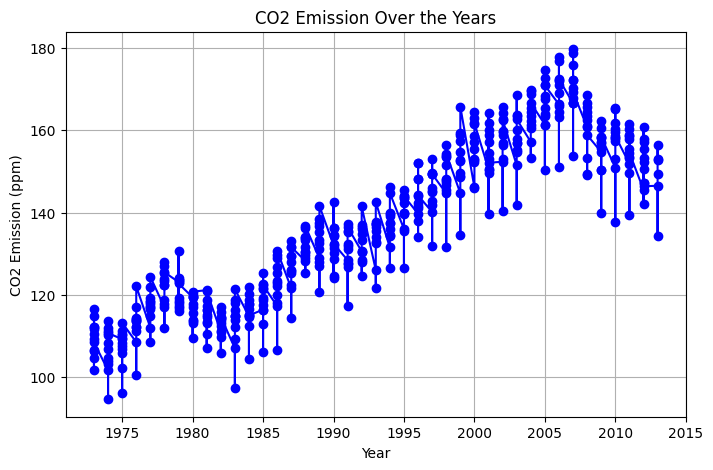

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(DataFile["Year"], DataFile["CO2 Emission"], marker="o", linestyle="-", color="b")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission Over the Years")
plt.grid(True)

# Show the plot
plt.show()

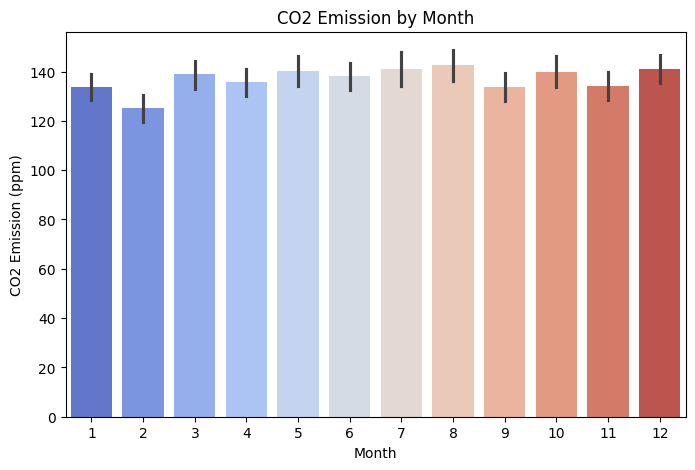

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(x=DataFile["Month"], y=DataFile["CO2 Emission"], palette="coolwarm")

# Labels and Title
plt.xlabel("Month")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission by Month")

# Show the plot
plt.show()

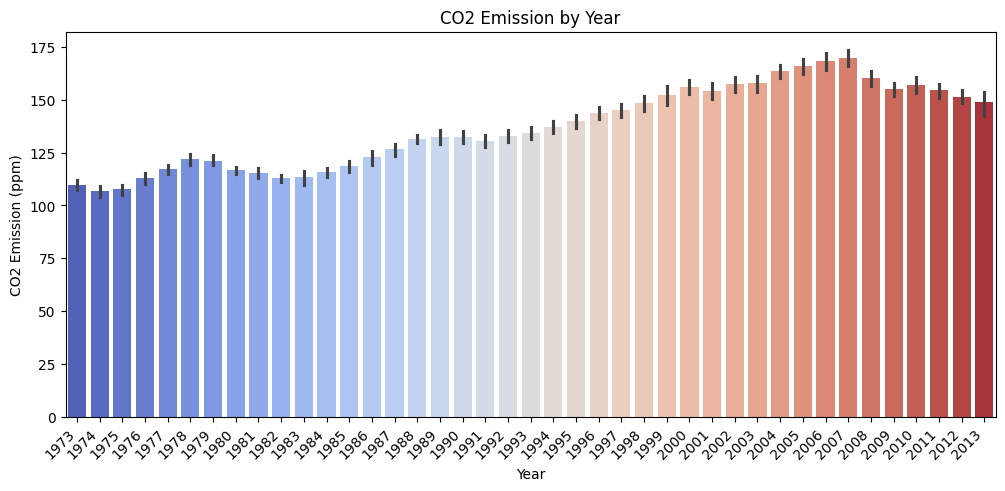

In [22]:
plt.figure(figsize=(12, 5))
sns.barplot(x=DataFile["Year"], y=DataFile["CO2 Emission"], palette="coolwarm")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission by Year")

plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

It's kind of a complex figure so we will group the years into ranges

In [23]:
min_year = DataFile["Year"].min()
max_year = DataFile["Year"].max()

print(min_year)
print(max_year)

1973
2013


In [24]:
bins = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]

labels = ["1971-1975", "1976-1980", "1981-1985", "1986-1990", "1991-1995", "1996-2000", "2001-2005", "2006-2010", "2011-2015"]

DataFile["Year Range"] = pd.cut(DataFile["Year"], bins=bins, labels=labels, right=True)
print(DataFile[["Year", "Year Range"]].head())

   Year Year Range
0  1973  1971-1975
1  1973  1971-1975
2  1973  1971-1975
3  1973  1971-1975
4  1973  1971-1975


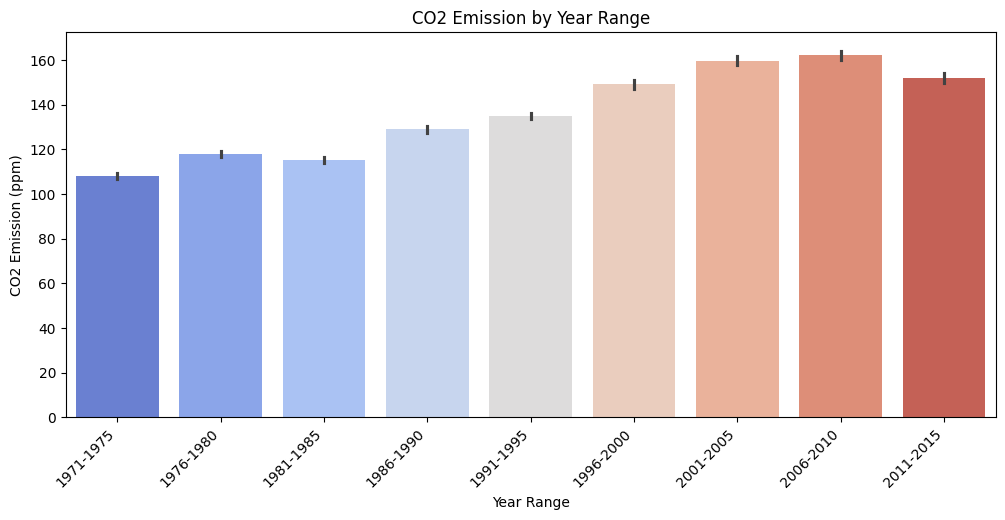

In [25]:
plt.figure(figsize=(12, 5))  # Increase width
sns.barplot(x=DataFile["Year Range"], y=DataFile["CO2 Emission"], palette="coolwarm")

plt.xlabel("Year Range")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission by Year Range")

plt.xticks(rotation=45, ha="right")  # Rotate labels for better spacing

plt.show()


In [26]:
DataFile.drop(columns=['Year Range'], inplace=True)

## Training Process !

In [27]:
DataFile = pd.read_csv("New Emission.csv") # reading our cleaned dataset
## Adding the year-month as our indecies !!
## useful when plotting on X axis using only **test.index** or **train.index** 
# as it contains all dates as indecies here !
DataFile['Date'] = pd.to_datetime(DataFile['Year'].astype(str) + '-' + DataFile['Month'].astype(str).str.zfill(2))
DataFile.set_index('Date', inplace=True)
DataFile = DataFile.asfreq('MS')  # Monthly Start frequency

## ARIMA AND SARIMA

In [28]:
# Train-test split
split_ratio = 0.8
train_size = int(len(DataFile) * split_ratio)
train, test = DataFile.iloc[:train_size], DataFile.iloc[train_size:]

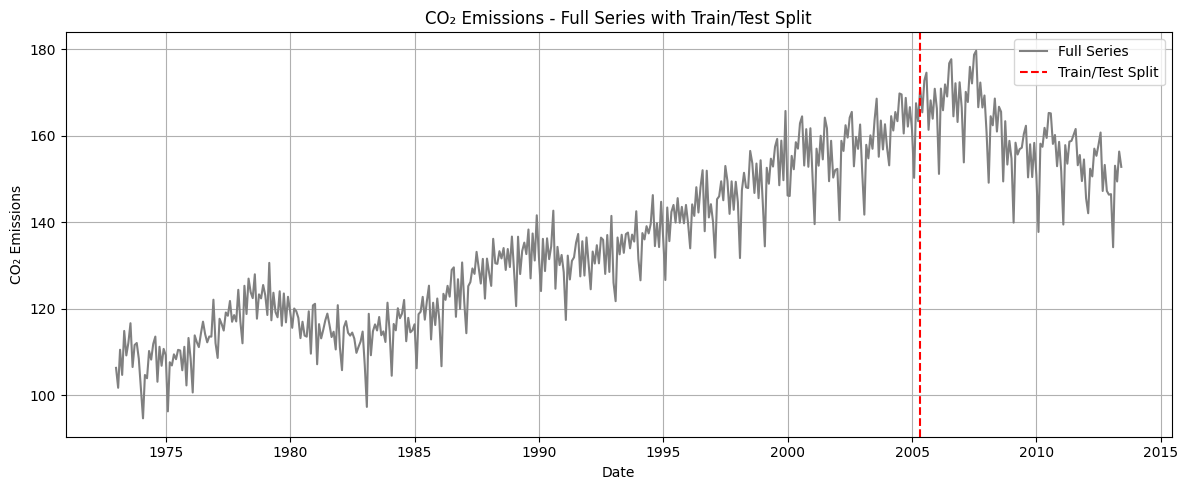

In [29]:
#Full time series with train/test split
plt.figure(figsize=(12, 5))
plt.plot(DataFile.index, DataFile['CO2 Emission'], label='Full Series', color='gray')
plt.axvline(test.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.title('CO₂ Emissions - Full Series with Train/Test Split')
plt.xlabel('Date')
plt.ylabel('CO₂ Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Helper function to evaluate for classic machine learning models in our case (Arima/Sarima)
def evaluate_forecast(y_true, y_pred):
    y_mean = np.mean(y_true)
    sce = np.sum((y_pred - y_mean) ** 2)
    sst = np.sum((y_true - y_mean) ** 2)
    
    return {
        "RMSE": np.sqrt(np.mean((y_pred-y_true)**2)),
        "MAE": np.mean(np.abs(y_pred - y_true)),
        "MAEP": np.mean(np.abs((y_pred - y_true) / y_true+ 1e-10)), # mape = 1/n * sum( abs(y_real - y_predicted) )
        "R²":  sce / sst # r2 = SCE / SST
    }
  
# Store results
results = {}

In [31]:
print("Training ARIMA...")
best_rmse = float('inf')
best_order = None
best_model = None
# Grid search ARIMA(p,d,q)

for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                start = perf_counter()
                model = ARIMA(train['CO2 Emission'], order=(p,d,q))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                elapsed = perf_counter() - start
                scores = evaluate_forecast(test['CO2 Emission'], forecast)
                if scores['RMSE'] < best_rmse:
                    best_rmse = scores['RMSE']
                    best_order = (p,d,q)
                    best_model = model_fit
                    results['ARIMA'] = {
                        "Order": best_order,
                        "Metrics": scores,
                        "Training Time (s)": elapsed
                    }
            except:
                continue

print("Best ARIMA order:", best_order)
print("ARIMA Results:", results['ARIMA'])

Training ARIMA...
Best ARIMA order: (3, 0, 2)
ARIMA Results: {'Order': (3, 0, 2), 'Metrics': {'RMSE': 8.395175637095523, 'MAE': 6.541859144474969, 'MAEP': 0.0411859357373455, 'R²': 0.042641974411375426}, 'Training Time (s)': 0.18324546700023348}


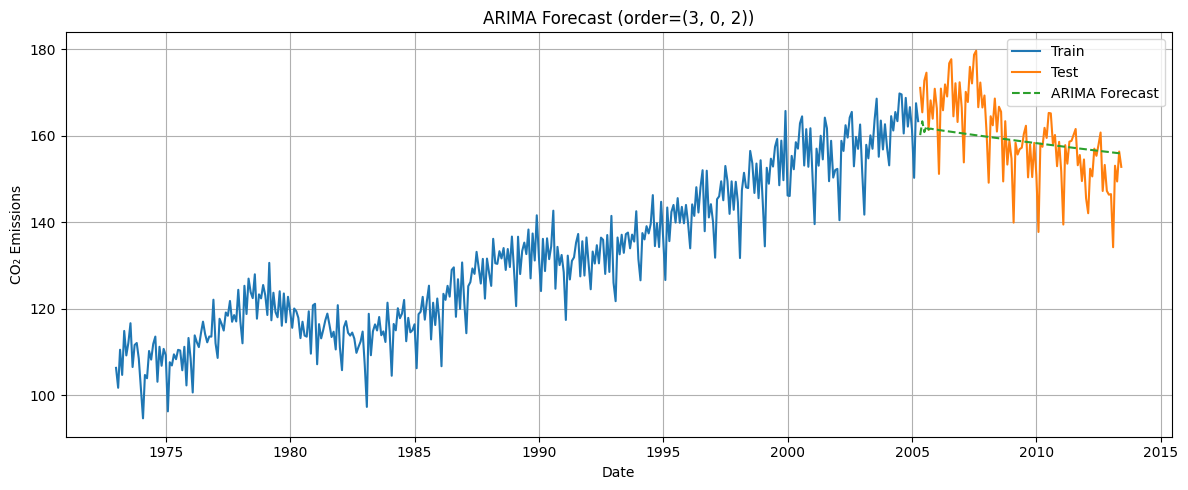

In [32]:
# Plot 2: ARIMA Forecast vs Actual
if 'ARIMA' in results:
    forecast_arima = best_model.forecast(steps=len(test))
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train['CO2 Emission'], label='Train')
    plt.plot(test.index, test['CO2 Emission'], label='Test')
    plt.plot(test.index, forecast_arima, label='ARIMA Forecast', linestyle='--')
    plt.title(f'ARIMA Forecast (order={results["ARIMA"]["Order"]})')
    plt.xlabel('Date')
    plt.ylabel('CO₂ Emissions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Saving arima metrics to csv file

In [33]:
arima_data = results['ARIMA']
arima_df = pd.DataFrame([{
    "Model": "ARIMA",
    "Order": arima_data["Order"],
    "RMSE": arima_data["Metrics"]["RMSE"],
    "MAE": arima_data["Metrics"]["MAE"],
    "R²": arima_data["Metrics"]["R²"],
    "Training Time (s)": arima_data["Training Time (s)"]
}])
# Save to CSV
arima_df.to_csv("metrics/arima_results.csv", index=False)

In [34]:
print("\nTraining SARIMA...")
best_rmse = float('inf')
best_order = None
best_seasonal = None
best_model = None

# Grid search SARIMA(p,d,q)(P,D,Q,s)

for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            for P in range(0, 2):
                for D in range(0, 2):
                    for Q in range(0, 2):
                        try:
                            start = perf_counter()
                            model = SARIMAX(train['CO2 Emission'], order=(p,d,q),
                                            seasonal_order=(P,D,Q,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                            model_fit = model.fit(disp=False)
                            forecast = model_fit.forecast(steps=len(test))
                            elapsed = perf_counter() - start
                            scores = evaluate_forecast(test['CO2 Emission'], forecast)
                            if scores['RMSE'] < best_rmse:
                                best_rmse = scores['RMSE']
                                best_order = (p,d,q)
                                best_seasonal = (P,D,Q,12)
                                best_model = model_fit
                                results['SARIMA'] = {
                                    "Order": best_order,
                                    "Seasonal Order": best_seasonal,
                                    "Metrics": scores,
                                    "Training Time (s)": elapsed
                                }
                        except:
                            continue

print("Best SARIMA order:", best_order, "seasonal:", best_seasonal)
print("SARIMA Results:", results['SARIMA'])


Training SARIMA...
Best SARIMA order: (2, 0, 0) seasonal: (1, 1, 1, 12)
SARIMA Results: {'Order': (2, 0, 0), 'Seasonal Order': (1, 1, 1, 12), 'Metrics': {'RMSE': 6.760460818909545, 'MAE': 5.880657418784956, 'MAEP': 0.03757375189620375, 'R²': 0.39745657176106547}, 'Training Time (s)': 0.34848526699988724}


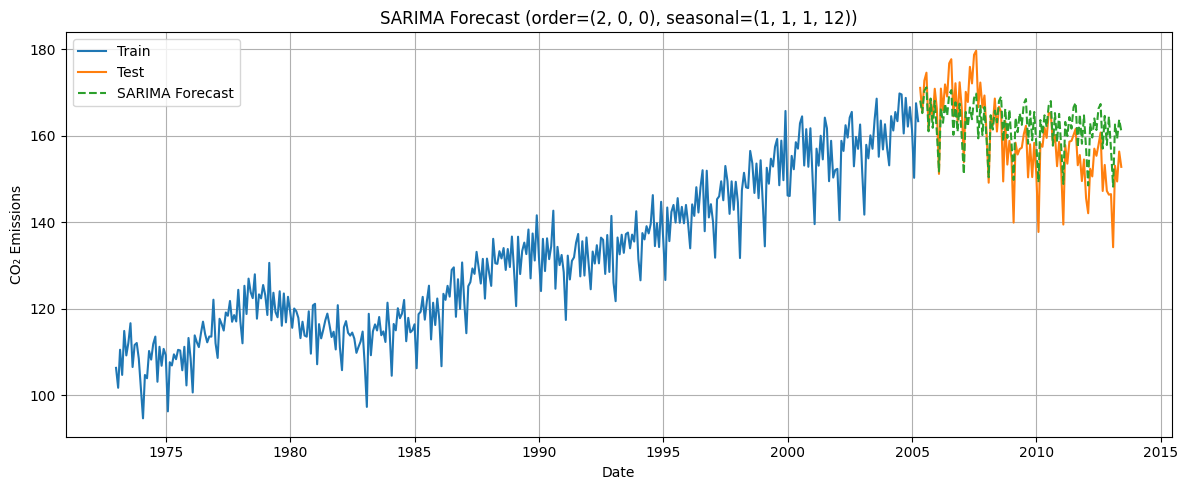

In [35]:
# Plot 3: SARIMA Forecast vs Actual
if 'SARIMA' in results:
    forecast_sarima = best_model.forecast(steps=len(test))
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train['CO2 Emission'], label='Train')
    plt.plot(test.index, test['CO2 Emission'], label='Test')
    plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', linestyle='--')
    plt.title(f'SARIMA Forecast (order={results["SARIMA"]["Order"]}, seasonal={results["SARIMA"]["Seasonal Order"]})')
    plt.xlabel('Date')
    plt.ylabel('CO₂ Emissions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Saving arima metrics to csv file

In [36]:
sarima_data = results['SARIMA']
sarima_df = pd.DataFrame([{
    "Model": "SARIMA",
    "Order": sarima_data["Order"],
    "Seasonal Order": sarima_data["Seasonal Order"],
    "RMSE": sarima_data["Metrics"]["RMSE"],
    "MAE": sarima_data["Metrics"]["MAE"],
    "R²": sarima_data["Metrics"]["R²"],
    "Training Time (s)": sarima_data["Training Time (s)"]
}])

# Save to CSV
sarima_df.to_csv("metrics/sarima_results.csv", index=False)
print("Saved to metrics/sarima_results.csv")

Saved to metrics/sarima_results.csv


## LSTM AND TRANSFORMERS


#### Both of these are EXTREAMLY SENSETIVE to the learning rate and the Reduction of LR function (ReduceLrOnPlateau)

In [37]:
X,y = X_y_forecasting_splits(DataFile,TIME_STEP) ## when time step = 1 it equals to using X,y from train test split !!
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten() ## using the scaled version of y ( values between <0 1>)

### LSTM

In [38]:
folds_histories = []
folds_metrics = []
lstm_perf_filename = 'metrics/lstm_performance.csv'
lstm_metrics_filename = 'metrics/lstm_metrics.csv'

time_series_split_folds = TimeSeriesSplit(n_splits=N_SPLITS)
for fold ,(training_idx, validation_idx) in enumerate(time_series_split_folds.split(X,y)):
    lstm_model = lstm_architecture(INPUT_SHAPE,LR,D_MODEL)

    X_train_cv = tf.convert_to_tensor(X[training_idx], dtype=tf.float32)
    X_val_cv = tf.convert_to_tensor(X[validation_idx], dtype=tf.float32)
    y_train_cv = tf.convert_to_tensor(y_scaled[training_idx], dtype=tf.float32)
    y_val_cv = tf.convert_to_tensor(y_scaled[validation_idx], dtype=tf.float32)
    
    train_start = perf_counter()
    history = lstm_model.fit(X_train_cv,y_train_cv,epochs=EPOCHS,validation_data=(X_val_cv,y_val_cv),callbacks=CALLBACK,verbose=0)
    train_end = perf_counter()
    
    val_loss, val_mae = lstm_model.evaluate(X_val_cv, y_val_cv,verbose=0)
    
    y_val_preds = lstm_model.predict(X_val_cv)
    # Reshaping to remove the extra dim
    y_val_preds_reshaped = y_val_preds.reshape(-1, 1) # from (dim1,1) to (dim1,)
    # to get the original co2 values not between 0-1 we apply inverse_transform
    y_val_preds_original = scaler.inverse_transform(y_val_preds_reshaped).flatten()

    # Reshaping to remove the extra dim
    y_val_reshaped = y_val_cv.numpy().reshape(-1, 1) # from (dim1,1) to (dim1,)
    # to get the original co2 values not between 0-1 we apply inverse_transform
    y_val_original = scaler.inverse_transform(y_val_reshaped).flatten()
    
    # Calculating the metrics :
    y_mean = np.mean(y_val_original)
    rmse_calculated = np.sqrt(np.mean((y_val_preds_original - y_val_original)**2))
    mae_calculated = np.mean(np.abs(y_val_preds_original - y_val_original))
    mape_calculated = np.mean(np.abs((y_val_preds_original - y_val_original) / y_val_original+ 1e-10)) # mape = 1/n * sum( abs(y_real - y_predicted) )
    
    sce = np.sum((y_val_preds_original - y_mean) ** 2)
    sst = np.sum((y_val_original - y_mean) ** 2)
    r2_calculated = sce / sst # r2 = SCE / SST
    
    fold_history = history.history.copy()
    fold_history['fold'] = fold
    folds_metrics.append({
        'fold':fold,
        'training_time':train_end-train_start,
        'rmse_calculated': rmse_calculated,
        'mae_calculated':mae_calculated,
        'mape_calculated':mape_calculated,
        'r2_calculated':r2_calculated
    })
    folds_histories.append(fold_history)
    
performance_df = pd.concat([pd.DataFrame(h) for h in folds_histories])
metrics_df = pd.DataFrame(folds_metrics)

performance_df.to_csv(lstm_perf_filename)
metrics_df.to_csv(lstm_metrics_filename)
lstm_model.save('models/lstm_model.keras')

2025-04-24 15:10:12.309966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 15:10:12.348715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 15:10:12.348752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 15:10:12.349712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 15:10:12.349764: I tensorflow/compile

3/3 [==============================] - 1s 5ms/step


### Transformer

In [39]:
folds_histories = []
folds_metrics = []
transformer_perf_filename = 'metrics/transformer12_performance.csv'
transformer_metrics_filename = 'metrics/transformer12_metrics.csv'

time_series_split_folds = TimeSeriesSplit(n_splits=N_SPLITS)
performance = []
for fold ,(training_idx, validation_idx) in enumerate(time_series_split_folds.split(X,y)):
    transformer_model = transformer_architecture(INPUT_SHAPE,LR,SEQ_LEN,D_MODEL,NUM_HEADS,KEY_DIM)

    X_train_cv = tf.convert_to_tensor(X[training_idx], dtype=tf.float32)
    X_val_cv = tf.convert_to_tensor(X[validation_idx], dtype=tf.float32)
    y_train_cv = tf.convert_to_tensor(y_scaled[training_idx], dtype=tf.float32)
    y_val_cv = tf.convert_to_tensor(y_scaled[validation_idx], dtype=tf.float32)
    
    train_start = perf_counter()
    history = transformer_model.fit(X_train_cv,y_train_cv,epochs=EPOCHS,validation_data=(X_val_cv,y_val_cv),callbacks=CALLBACK,verbose=0)
    train_end = perf_counter()
    
    val_loss, val_mae = transformer_model.evaluate(X_val_cv, y_val_cv,verbose=0)
    
    y_val_preds = transformer_model.predict(X_val_cv)
    # Reshaping to remove the extra dim
    y_val_preds_reshaped = y_val_preds.reshape(-1, 1) # from (dim1,1) to (dim1,)
    # to get the original co2 values not between 0-1 we apply inverse_transform
    y_val_preds_original = scaler.inverse_transform(y_val_preds_reshaped).flatten()

    # Reshaping to remove the extra dim
    y_val_reshaped = y_val_cv.numpy().reshape(-1, 1) # from (dim1,1) to (dim1,)
    # to get the original co2 values not between 0-1 we apply inverse_transform
    y_val_original = scaler.inverse_transform(y_val_reshaped).flatten()
    
    # Calculating the metrics :
    y_mean = np.mean(y_val_original)
    rmse_calculated = np.sqrt(np.mean((y_val_preds_original - y_val_original)**2))
    mae_calculated = np.mean(np.abs(y_val_preds_original - y_val_original))
    mape_calculated = np.mean(np.abs((y_val_preds_original - y_val_original) / y_val_original)) # mape = 1/n * sum( abs(y_real - y_predicted) )
    
    sce = np.sum((y_val_preds_original - y_mean) ** 2)
    sst = np.sum((y_val_original - y_mean) ** 2)
    r2_calculated = sce / sst # r2 = SCE / SST
    
    fold_history = history.history.copy()
    fold_history['fold'] = fold
    folds_metrics.append({
        'fold':fold,
        'training_time':train_end-train_start,
        'rmse_calculated': rmse_calculated,
        'mae_calculated':mae_calculated,
        'mape_calculated':mape_calculated,
        'r2_calculated':r2_calculated
    })
    folds_histories.append(fold_history)
    
performance_df = pd.concat([pd.DataFrame(h) for h in folds_histories])
metrics_df = pd.DataFrame(folds_metrics)

performance_df.to_csv(transformer_perf_filename)
metrics_df.to_csv(transformer_metrics_filename)
transformer_model.save('models/transformer12_model.keras')

3/3 [==============================] - 0s 10ms/step


## NOTE from **abdelhak** : to make predictions using lstm or the transformer:
- The shape of the input we feed to the transformer or lstm is (Batch Size , Time Step , features)
Where in our case **time_step = 1, features = 3** and batch size decided by train_test split OR cross val, so its necessary to reshape the input of **.predict()** function to **.reshape(-1,1,3)**

- We need to 'inverse transform' the result using the scaler (MinMax) defined above, cause the predictions are <0-1> values not in the real CO2 values: **predictions = scaler.inverse_transform(preds.reshape(-1,1)).flatten()** this will CONVERT THE PREDS FROM <0-1> into REAL LIFE Values.
---

## IN CASE OF TIME_STEP > 1 (We take multiple instances as input > 1 output )
- Like forecasting for next 4th month using the last 3 months ( ex: TIME_STEP = 3 )
- Using this line : **test_trimmed = test[-len(predictions):]**, with it we could plot our predictions based on our test data or Any data, this trim is necessary cause our input data is using a WINDOW function with step of 'TIME_STEP' defined above.
---

## Another Note About Visualization of deep learning models:
- In **Metrics Folder** you find all my metrics and performances, to plot them its better to average the values cause in these csv files there is the records about all folds of **cross validation**, not a single fold, so its better to **AVERAGE the performance Arrays** (Errors etc...)
- **OR** Simply taking the last fold metrics (ex: 'fold'= 4 metrics )


### Making Prediction for the next year

In [64]:
## Here its possible to load a saved model and use it for the first function parameter
years = 1 ## how much years we want
predicted_dates,stacked_predictions = next_year_predictions(transformer_model,X,scaler,years=years)

1/1 [==============================] - 0s 21ms/step
MY PREDS :[[[ 156.784 2013.       6.   ]
  [ 156.789 2013.       7.   ]
  [ 156.639 2013.       8.   ]
  [ 155.18  2013.       9.   ]
  [ 155.691 2013.      10.   ]
  [ 155.471 2013.      11.   ]
  [ 155.906 2013.      12.   ]
  [ 156.22  2014.       1.   ]
  [ 156.476 2014.       2.   ]
  [ 159.43  2014.       3.   ]
  [ 159.886 2014.       4.   ]
  [ 161.338 2014.       5.   ]]]
stacked is added and predicting first year is done


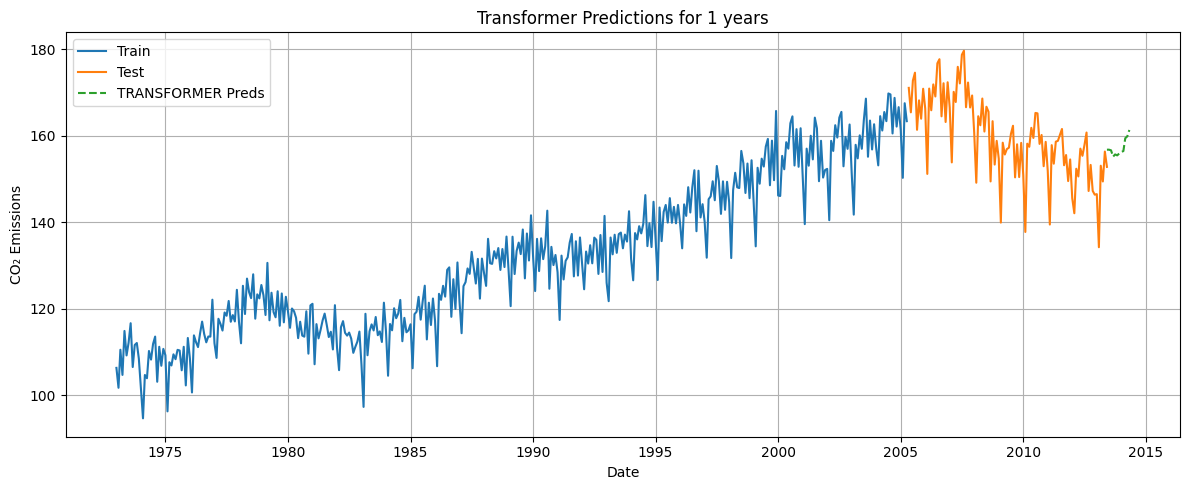

In [65]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['CO2 Emission'], label='Train')
plt.plot(test.index, test['CO2 Emission'], label='Test')
plt.plot(predicted_dates, stacked_predictions[0,:,0], label='TRANSFORMER Preds', linestyle='--')
plt.title(f'Transformer Predictions for {years} years')
plt.xlabel('Date')
plt.ylabel('CO₂ Emissions')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
stacked_predictions = pd.DataFrame(stacked_predictions[0,:],columns=DataFile.columns)
stacked_predictions.to_csv('next_year_preds.csv')

In [55]:
print(stacked_predictions)

    CO2 Emission    Year  Month
0     156.784241  2013.0    6.0
1     156.789398  2013.0    7.0
2     156.639450  2013.0    8.0
3     155.180008  2013.0    9.0
4     155.690582  2013.0   10.0
5     155.470612  2013.0   11.0
6     155.906265  2013.0   12.0
7     156.219818  2014.0    1.0
8     156.476273  2014.0    2.0
9     159.430374  2014.0    3.0
10    159.886002  2014.0    4.0
11    161.338379  2014.0    5.0


- These values are acceptable, given the well-documented **annual increase** in atmospheric CO₂ levels<a href='https://www.statista.com/statistics/276629/global-co2-emissions/' > From This Website</a>

<div align="center">
  <img src="static/co2_emissions_google.png" width="800" height="500"/>
</div>

## Metrics Visualization Here: